In [8]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import numpy as np
import powerlaw
import math
from sklearn.preprocessing import OneHotEncoder

## read dataset function

In [9]:
def load_flle(filename):
    x = []
    with open(filename) as f:
        line = f.readline()
        line = line.strip('\n')
    return line

def dirlist(path, files):
    filelist = os.listdir(path)

    for filename in filelist:
        filepath = os.path.join(path, filename)
        if os.path.isdir(filepath):
            dirlist(filepath, files)
        else:
            files.append(filepath)
    return files

def load_train_files(path):
    x = []
    y = []
    list = os.listdir(path)
    for i in range(0, len(list)):
        path2 = os.path.join(path, list[i])
        if os.path.isfile(path2):
            x.append(load_flle(path2))
            y.append(0)
    return x, y


def load_attack_files(path, x, y, attack_type):
    # return x:length of each attack file
    total = 0
    for i in range(1,11): 
        # each attack has 10 folder 
        files = dirlist(path + attack_type +"_" + str(i), [])
        total = total + len(files)
        for file in files:
            x.append(load_flle(file))
            y.append(1)
    print(attack_type + " data: " + str(total))
    return x, y

def get_increasing_array(length):
    arr = np.zeros(length)
    for i in range(length):
        arr[i] = i
    return arr

def calculate_attack_syscall_avg(attack_type):
    x_orig = []
    x_extend = []
    y_orig = []
    y_extend = []

    x_orig, y_orig = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig, y_orig, attack_type)
    fileIndex = 0 # attack count
    totalLen = 0
    x_avglen = 0
    for d in x_orig:
        d = d.rstrip()
        fileIndex+=1
        if (fileIndex == 1): print(fileIndex, ": ", d, "\nThe syscall length of this attack file: ", len(d.split(' ')),  "\n")
        totalLen += len(d.split(' '))

    x_avglen = totalLen / len(x_orig)
    print("Avg", attack_type, "system call length:", x_avglen, "\n")
    return x_avglen

## read data

In [ ]:
attack_type = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Web_Shell']
xa = []
ya = []
for attack in attack_type:
    xa, ya = load_attack_files("ADFA-LD/Attack_Data_Master/", xa, ya, attack) # 746
xt, yt = load_train_files("ADFA-LD/Training_Data_Master/")  # 833
xv, yv = load_train_files("ADFA-LD/Validation_Data_Master/")  # 4372

# training data
x_trn = xt + xa
y_trn = yt + ya

# validation data
x_val = xv 
y_val = yv 


## Parameter

In [88]:
n = 2
left = 0
right = 10

### Normal

In [ ]:
dic_normal = defaultdict(lambda: 0)
for d in xt:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal[index] = dic_normal[index] + 1

lists = sorted(dic_normal.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Training Data")
plt.plot(px, py)
plt.show()
print(px)
print(py)

### adduser

In [10]:
"""
x_addusr_orig = []
x_addusr_extend = []
y_addusr_orig = []
y_addusr_extend = []

x_addusr_orig, y_addusr_orig = load_attack_files("ADFA-LD/Attack_Data_Master/", x_addusr_orig, y_addusr_orig, 'Adduser')
fileIndex = 0 # adduser attack count
totalLen = 0
x_addusr_avglen = 0
for d in x_addusr_orig:
    fileIndex+=1
    print(fileIndex, ": ", d, "\nThe syscall length of this attack file: ", len(d.split(' '))-1,  "\n")
    totalLen += len(d.split(' ')) - 1
    
x_addusr_avglen = totalLen / len(x_addusr_orig)
print("Avg adduser system call length:", x_addusr_avglen)
"""

calculate_attack_syscall_avg("Adduser")
calculate_attack_syscall_avg("Hydra_FTP")
calculate_attack_syscall_avg("Hydra_SSH")
calculate_attack_syscall_avg("Java_Meterpreter")
calculate_attack_syscall_avg("Meterpreter")
calculate_attack_syscall_avg("Web_Shell")

Adduser data: 91
1 :  265 168 168 265 168 168 168 265 168 265 168 168 168 168 168 168 168 168 102 168 265 265 168 168 168 265 265 168 168 168 168 265 102 265 265 168 168 168 168 265 168 168 265 102 168 168 168 168 168 168 168 168 168 265 168 168 168 168 168 168 265 168 168 168 168 265 265 265 168 265 168 265 168 168 168 168 168 168 168 265 168 265 168 168 168 168 168 102 168 265 265 168 168 168 168 265 168 168 265 265 168 168 168 168 265 265 168 168 168 265 168 265 168 168 265 265 265 265 265 168 168 265 168 265 168 168 168 265 168 168 168 168 265 168 265 168 168 168 168 168 168 168 168 265 168 168 168 168 168 168 168 265 168 168 168 168 168 168 265 102 168 265 168 168 265 168 265 265 265 265 168 265 265 168 168 168 168 168 168 168 102 265 168 265 168 265 168 168 168 168 168 168 168 265 265 168 168 265 265 265 168 102 168 265 168 168 168 168 168 265 168 168 168 102 168 168 168 168 168 168 168 168 265 265 168 265 168 168 265 265 265 265 168 168 168 168 168 265 168 168 168 168 168 168 16

490.8728813559322

### sampling attack data

In [106]:
# calu the n-gram, and save them into a dictionary
def calu_ngram(n, attack_type):
    x_orig = []
    y_orig = []
    x_orig, y_orig = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig, y_orig, attack_type)
    print(len(x_orig))
    if (attack_type == "Hydra_FTP"):
        x_orig2 = []
        y_orig2 = []
        x_orig2, y_orig2 = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig2, y_orig2, "Hydra_SSH")
    if (attack_type == "Java_Meterpreter"):
        x_orig2 = []
        y_orig2 = []
        x_orig2, y_orig2 = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig2, y_orig2, "Meterpreter")
    x_orig += x_orig2
    print("total:", len(x_orig))
    
    dic_ngram = defaultdict(lambda: 0)
    
    # Attack data n-gram
    for d in x_orig:
        data = d.strip().split(' ')
        for i in range(len(data) - n + 1):
            index = ' '.join(data[i:i+n])
            dic_ngram[index] = dic_ngram[index] + 1
    #print(dic_ngram)
    out = sorted(dic_ngram.items(), key=lambda kv: kv[1], reverse=True)
    print( attack_type, "top 10-gram:", list(out[0][0].strip().split(' ')), list(out[1][0].strip().split(' ')) )
    for i in out:
        print(i)
    
    
#calu_ngram(10, "Adduser")
#calu_ngram(10, "Hydra_FTP") # Hydra_FTP + Hydra_SSH
calu_ngram(10, "Java_Meterpreter") # Java_Meterpreter + Meterpreter
#calu_ngram(10, "Web_Shell")

Java_Meterpreter data: 124
124
Meterpreter data: 75
total: 199
Java_Meterpreter top 10-gram: ['78', '78', '78', '78', '78', '78', '78', '78', '78', '78'] ['195', '195', '195', '195', '195', '195', '195', '195', '195', '195']
('78 78 78 78 78 78 78 78 78 78', 1243)
('195 195 195 195 195 195 195 195 195 195', 332)
('162 162 162 162 162 162 162 162 162 162', 249)
('174 174 174 174 174 174 174 174 174 174', 242)
('240 240 240 240 240 240 240 240 240 240', 207)
('3 78 78 78 78 78 78 78 78 78', 127)
('162 162 162 162 162 114 162 162 162 162', 115)
('162 162 162 162 114 162 162 162 162 162', 106)
('162 162 162 162 162 162 114 162 162 162', 105)
('78 3 78 78 78 78 78 78 78 78', 102)
('78 78 3 78 78 78 78 78 78 78', 101)
('162 162 162 114 162 162 162 162 162 162', 101)
('162 162 162 162 162 162 162 114 162 162', 97)
('78 78 78 78 3 78 78 78 78 78', 95)
('78 78 78 78 78 78 78 78 3 78', 93)
('78 78 78 78 78 78 78 3 78 78', 92)
('78 78 78 78 78 78 78 78 78 3', 91)
('78 78 78 78 78 3 78 78 78 78', 

('114 162 162 114 162 162 114 162 114 162', 4)
('114 114 114 114 162 162 114 162 162 162', 4)
('162 162 162 114 162 162 162 114 114 114', 4)
('162 162 114 114 162 162 114 162 162 114', 4)
('162 162 162 114 114 162 162 162 114 114', 4)
('162 162 114 114 162 162 162 114 114 162', 4)
('162 114 162 114 114 162 162 162 162 114', 4)
('162 114 162 162 114 114 114 114 162 162', 4)
('114 162 162 162 114 114 162 162 162 114', 4)
('162 162 162 114 114 162 114 162 114 162', 4)
('114 114 162 114 162 114 162 162 162 162', 4)
('265 168 168 265 265 168 265 265 168 168', 4)
('265 168 265 265 265 168 265 168 265 168', 4)
('265 265 265 168 265 168 265 168 265 265', 4)
('265 168 265 168 265 168 265 265 168 168', 4)
('168 168 265 265 168 265 265 265 265 265', 4)
('265 265 265 168 168 168 168 265 168 265', 4)
('78 78 3 78 78 78 78 140 78 78', 4)
('78 196 196 78 78 78 78 78 78 78', 4)
('78 140 78 78 78 78 78 78 3 78', 4)
('140 78 78 78 78 78 78 3 78 78', 4)
('78 78 78 78 78 78 78 196 196 78', 4)
('78 78 78 7

('168 168 168 168 265 3 265 168 265 168', 3)
('3 265 168 3 3 265 168 168 168 168', 3)
('265 265 3 265 168 168 265 265 265 265', 3)
('265 3 265 168 168 265 265 265 265 265', 3)
('168 265 265 265 265 265 3 265 168 265', 3)
('265 265 265 265 3 265 168 265 265 168', 3)
('265 265 265 3 265 168 265 265 168 3', 3)
('265 3 168 265 265 168 3 168 168 3', 3)
('168 168 3 168 265 265 168 168 168 3', 3)
('168 265 168 168 3 168 265 265 168 168', 3)
('168 168 168 168 265 168 3 168 168 3', 3)
('265 168 265 265 168 168 168 168 265 3', 3)
('265 168 265 3 265 168 265 168 168 168', 3)
('265 168 265 168 168 168 3 168 168 265', 3)
('265 168 168 168 3 168 168 265 168 168', 3)
('168 168 3 168 168 265 168 168 3 168', 3)
('168 265 168 168 265 168 265 265 3 168', 3)
('3 168 168 168 3 3 168 168 265 168', 3)
('168 168 3 168 265 168 168 3 168 168', 3)
('168 3 168 265 168 168 3 168 168 168', 3)
('168 168 168 265 168 3 168 168 3 168', 3)
('168 265 168 3 168 265 168 168 265 265', 3)
('168 265 168 168 265 168 265 265 26

('168 168 168 168 265 265 265 3 265 3', 2)
('3 3 3 168 3 265 168 168 265 168', 2)
('265 168 265 265 3 168 168 168 168 265', 2)
('168 265 265 3 168 168 168 168 265 168', 2)
('265 265 3 168 168 168 168 265 168 168', 2)
('265 168 168 265 265 265 265 168 265 3', 2)
('265 265 265 265 168 265 3 265 265 168', 2)
('265 265 265 168 265 3 265 265 168 265', 2)
('168 265 3 265 265 168 265 3 265 265', 2)
('265 3 265 265 168 265 3 265 265 168', 2)
('265 3 265 265 168 265 168 265 3 168', 2)
('265 168 265 168 265 3 168 265 168 3', 2)
('168 265 3 168 265 168 3 168 168 168', 2)
('3 168 265 168 3 168 168 168 3 265', 2)
('168 168 168 3 265 265 265 3 3 265', 2)
('3 265 265 265 3 3 265 168 3 265', 2)
('3 265 168 3 265 265 3 265 265 168', 2)
('265 168 3 265 265 3 265 265 168 168', 2)
('168 168 168 3 265 168 3 265 265 265', 2)
('168 3 265 265 265 265 265 168 168 168', 2)
('265 265 265 168 168 168 3 3 265 3', 2)
('3 3 168 168 168 265 3 168 168 168', 2)
('168 168 168 265 3 168 168 168 3 265', 2)
('168 168 265 3

('168 168 3 3 3 168 3 3 3 3', 2)
('168 3 3 3 3 3 3 3 3 3', 2)
('3 3 3 3 3 3 3 3 3 168', 2)
('3 3 3 3 3 3 3 168 168 3', 2)
('3 3 3 3 3 3 168 168 3 3', 2)
('3 3 3 3 168 3 3 3 3 168', 2)
('3 3 168 3 3 3 3 168 3 3', 2)
('195 195 195 195 195 196 196 78 33 33', 2)
('195 195 195 195 196 196 78 33 33 33', 2)
('195 195 195 196 196 78 33 33 33 195', 2)
('195 195 196 196 78 33 33 33 195 195', 2)
('195 196 196 78 33 33 33 195 195 195', 2)
('196 196 78 33 33 33 195 195 195 195', 2)
('196 78 33 33 33 195 195 195 195 195', 2)
('78 33 33 33 195 195 195 195 195 196', 2)
('78 240 240 78 240 240 78 265 78 265', 2)
('240 78 240 240 78 265 78 265 240 78', 2)
('78 240 240 78 265 78 265 240 78 240', 2)
('240 78 265 78 265 240 78 240 240 240', 2)
('78 265 78 265 240 78 240 240 240 78', 2)
('265 78 265 240 78 240 240 240 78 240', 2)
('78 265 240 78 240 240 240 78 240 240', 2)
('240 265 265 240 240 240 240 240 240 78', 2)
('240 240 240 240 240 265 240 265 240 78', 2)
('78 78 240 240 240 78 240 240 78 78', 2)
('

('3 168 265 265 3 168 3 265 168 265', 2)
('265 3 168 3 265 168 265 3 265 265', 2)
('3 265 168 265 3 265 265 168 168 265', 2)
('3 168 3 168 265 265 168 265 265 168', 2)
('168 168 168 265 3 168 265 168 168 3', 2)
('168 265 3 168 265 168 168 3 168 265', 2)
('265 3 168 265 168 168 3 168 265 168', 2)
('168 265 3 265 168 3 265 265 168 265', 2)
('3 265 168 3 265 265 168 265 265 168', 2)
('265 168 168 168 168 265 168 168 168 3', 2)
('3 168 168 3 265 265 168 168 168 168', 2)
('168 168 3 265 265 168 168 168 168 265', 2)
('168 3 265 265 168 168 168 168 265 265', 2)
('3 265 265 168 168 168 168 265 265 265', 2)
('265 265 3 265 168 168 265 3 265 168', 2)
('265 3 265 168 265 3 265 3 265 168', 2)
('265 3 265 168 3 168 265 265 265 265', 2)
('265 168 3 168 265 265 265 265 3 265', 2)
('3 168 265 265 265 265 3 265 265 265', 2)
('265 265 265 265 3 265 265 265 265 3', 2)
('265 3 265 168 265 3 265 265 168 3', 2)
('265 168 265 3 265 265 168 3 168 265', 2)
('265 168 3 265 168 168 168 168 3 3', 2)
('265 168 168

('265 3 168 265 265 265 265 3 3 265', 2)
('3 168 265 265 265 265 3 3 265 265', 2)
('3 265 168 168 168 3 265 168 3 168', 2)
('3 168 168 3 3 265 168 265 168 3', 2)
('168 168 3 3 265 168 265 168 3 3', 2)
('168 3 3 168 265 168 3 265 265 265', 2)
('265 3 265 168 265 3 3 168 3 168', 2)
('3 168 168 168 3 168 265 168 265 168', 2)
('168 168 168 3 168 265 168 265 168 168', 2)
('3 265 3 265 265 168 168 265 265 168', 2)
('265 265 168 168 265 3 168 265 168 265', 2)
('168 265 3 168 265 168 265 168 265 265', 2)
('265 3 168 265 168 265 168 265 265 168', 2)
('168 3 3 3 168 265 265 265 3 265', 2)
('3 3 168 265 265 265 3 265 3 3', 2)
('3 168 265 265 265 3 265 3 3 168', 2)
('168 265 265 265 3 265 3 3 168 265', 2)
('265 265 168 168 168 265 265 168 3 265', 2)
('265 3 265 168 168 265 265 3 3 3', 2)
('3 265 3 168 265 168 265 168 265 3', 2)
('168 265 168 168 3 265 168 168 168 3', 2)
('168 3 168 3 3 168 168 265 265 168', 2)
('265 168 3 168 3 265 168 265 168 168', 2)
('168 3 265 168 265 168 168 168 3 3', 2)
('3 

('240 265 78 240 240 78 78 240 240 240', 1)
('240 240 265 240 240 78 240 240 78 240', 1)
('240 265 240 240 78 240 240 78 240 265', 1)
('265 240 240 78 240 240 78 240 265 78', 1)
('240 240 78 240 240 78 240 265 78 265', 1)
('240 78 240 240 78 240 265 78 265 240', 1)
('240 78 240 265 78 265 240 240 240 240', 1)
('78 240 265 78 265 240 240 240 240 240', 1)
('240 265 78 265 240 240 240 240 240 78', 1)
('265 78 265 240 240 240 240 240 78 265', 1)
('78 265 240 240 240 240 240 78 265 78', 1)
('265 240 240 240 240 240 78 265 78 265', 1)
('240 240 78 265 78 265 240 78 78 240', 1)
('240 78 265 78 265 240 78 78 240 265', 1)
('78 265 78 265 240 78 78 240 265 240', 1)
('265 78 265 240 78 78 240 265 240 240', 1)
('78 265 240 78 78 240 265 240 240 240', 1)
('265 240 78 78 240 265 240 240 240 240', 1)
('240 78 78 240 265 240 240 240 240 78', 1)
('78 240 265 240 240 240 240 78 78 265', 1)
('240 265 240 240 240 240 78 78 265 78', 1)
('265 240 240 240 240 78 78 265 78 78', 1)
('240 240 240 240 78 78 265 

('3 104 175 175 3 142 142 104 146 3', 1)
('104 175 175 3 142 142 104 146 3 142', 1)
('175 175 3 142 142 104 146 3 142 3', 1)
('175 3 142 142 104 146 3 142 3 146', 1)
('3 142 142 104 146 3 142 3 146 175', 1)
('142 142 104 146 3 142 3 146 175 3', 1)
('142 104 146 3 142 3 146 175 3 142', 1)
('104 146 3 142 3 146 175 3 142 142', 1)
('146 3 142 3 146 175 3 142 142 265', 1)
('3 142 3 146 175 3 142 142 265 104', 1)
('142 3 146 175 3 142 142 265 104 265', 1)
('3 146 175 3 142 142 265 104 265 104', 1)
('146 175 3 142 142 265 104 265 104 142', 1)
('175 3 142 142 265 104 265 104 142 175', 1)
('3 142 142 265 104 265 104 142 175 3', 1)
('142 142 265 104 265 104 142 175 3 265', 1)
('142 265 104 265 104 142 175 3 265 265', 1)
('265 104 265 104 142 175 3 265 265 175', 1)
('104 265 104 142 175 3 265 265 175 142', 1)
('265 104 142 175 3 265 265 175 142 104', 1)
('104 142 175 3 265 265 175 142 104 146', 1)
('142 175 3 265 265 175 142 104 146 142', 1)
('175 3 265 265 175 142 104 146 142 142', 1)
('3 265 2

('265 168 265 168 168 168 265 265 265 265', 1)
('168 168 168 265 265 265 265 3 265 265', 1)
('265 265 265 265 3 265 265 168 265 168', 1)
('265 3 265 265 168 265 168 168 3 168', 1)
('3 265 265 168 265 168 168 3 168 265', 1)
('265 265 168 265 168 168 3 168 265 3', 1)
('265 168 265 168 168 3 168 265 3 265', 1)
('168 265 168 168 3 168 265 3 265 168', 1)
('3 265 168 168 265 265 265 168 265 3', 1)
('265 168 168 265 265 265 168 265 3 168', 1)
('168 265 3 168 265 265 3 265 168 265', 1)
('265 3 168 265 265 3 265 168 265 265', 1)
('265 168 265 265 168 3 3 265 265 3', 1)
('168 265 265 168 3 3 265 265 3 265', 1)
('265 265 168 3 3 265 265 3 265 168', 1)
('265 168 3 3 265 265 3 265 168 3', 1)
('168 3 3 265 265 3 265 168 3 3', 1)
('3 3 265 265 3 265 168 3 3 3', 1)
('3 265 265 3 265 168 3 3 3 3', 1)
('265 265 3 265 168 3 3 3 3 265', 1)
('265 3 265 168 3 3 3 3 265 265', 1)
('3 265 168 3 3 3 3 265 265 265', 1)
('265 168 3 3 3 3 265 265 265 265', 1)
('3 3 3 3 265 265 265 265 265 3', 1)
('3 168 168 265 3 

('265 240 240 78 240 240 240 240 78 240', 1)
('240 240 78 240 240 240 240 78 240 78', 1)
('240 78 240 240 240 240 78 240 78 240', 1)
('240 240 240 240 78 240 78 240 78 265', 1)
('240 240 240 78 240 78 240 78 265 265', 1)
('240 240 78 240 78 240 78 265 265 240', 1)
('240 78 240 78 240 78 265 265 240 78', 1)
('78 240 78 240 78 265 265 240 78 240', 1)
('240 78 240 78 265 265 240 78 240 240', 1)
('78 240 78 265 265 240 78 240 240 240', 1)
('240 78 265 265 240 78 240 240 240 240', 1)
('78 265 265 240 78 240 240 240 240 240', 1)
('240 240 240 78 78 240 78 78 78 78', 1)
('240 240 78 78 240 78 78 78 78 78', 1)
('240 78 78 240 78 78 78 78 78 78', 1)
('78 78 78 78 78 78 240 240 240 265', 1)
('78 78 78 78 78 240 240 240 265 240', 1)
('78 78 78 78 240 240 240 265 240 240', 1)
('78 78 78 240 240 240 265 240 240 265', 1)
('78 78 240 240 240 265 240 240 265 240', 1)
('78 240 240 240 265 240 240 265 240 78', 1)
('240 240 240 265 240 240 265 240 78 240', 1)
('265 240 240 265 240 78 240 240 240 78', 1)


('168 168 146 168 168 168 3 146 3 168', 1)
('168 146 168 168 168 3 146 3 168 168', 1)
('146 168 168 168 3 146 3 168 168 265', 1)
('168 168 168 3 146 3 168 168 265 3', 1)
('168 168 3 146 3 168 168 265 3 168', 1)
('168 3 146 3 168 168 265 3 168 168', 1)
('3 146 3 168 168 265 3 168 168 3', 1)
('146 3 168 168 265 3 168 168 3 168', 1)
('168 168 265 3 168 168 3 168 265 4', 1)
('168 265 3 168 168 3 168 265 4 19', 1)
('265 3 168 168 3 168 265 4 19 146', 1)
('3 168 168 3 168 265 4 19 146 3', 1)
('168 168 3 168 265 4 19 146 3 168', 1)
('168 3 168 265 4 19 146 3 168 146', 1)
('3 168 265 4 19 146 3 168 146 168', 1)
('168 265 4 19 146 3 168 146 168 168', 1)
('265 4 19 146 3 168 146 168 168 168', 1)
('4 19 146 3 168 146 168 168 168 3', 1)
('19 146 3 168 146 168 168 168 3 168', 1)
('146 3 168 146 168 168 168 3 168 168', 1)
('3 168 146 168 168 168 3 168 168 3', 1)
('168 146 168 168 168 3 168 168 3 168', 1)
('168 3 168 168 3 265 168 3 3 3', 1)
('3 168 168 3 265 168 3 3 3 265', 1)
('168 168 3 265 168 3 

('197 6 195 5 195 195 5 5 195 6', 1)
('6 195 5 195 195 5 5 195 6 197', 1)
('195 5 195 195 5 5 195 6 197 195', 1)
('5 195 195 5 5 195 6 197 195 195', 1)
('195 195 5 5 195 6 197 195 195 195', 1)
('195 5 5 195 6 197 195 195 195 195', 1)
('5 5 195 6 197 195 195 195 195 195', 1)
('5 195 6 197 195 195 195 195 195 168', 1)
('195 6 197 195 195 195 195 195 168 146', 1)
('6 197 195 195 195 195 195 168 146 168', 1)
('197 195 195 195 195 195 168 146 168 168', 1)
('195 195 195 195 195 168 146 168 168 146', 1)
('195 195 195 195 168 146 168 168 146 168', 1)
('195 195 195 168 146 168 168 146 168 146', 1)
('195 195 168 146 168 168 146 168 146 196', 1)
('195 168 146 168 168 146 168 146 196 196', 1)
('168 146 168 168 146 168 146 196 196 78', 1)
('146 168 168 146 168 146 196 196 78 196', 1)
('168 168 146 168 146 196 196 78 196 78', 1)
('168 146 168 146 196 196 78 196 78 78', 1)
('146 168 146 196 196 78 196 78 78 78', 1)
('168 146 196 196 78 196 78 78 78 196', 1)
('146 196 196 78 196 78 78 78 196 78', 1)
(

('3 3 3 265 265 168 265 265 168 265', 1)
('3 3 265 265 168 265 265 168 265 168', 1)
('3 265 265 168 265 265 168 265 168 265', 1)
('265 265 168 265 168 265 265 3 168 3', 1)
('265 168 265 265 3 168 3 168 265 168', 1)
('168 265 265 3 168 3 168 265 168 168', 1)
('168 168 168 265 265 3 168 168 265 3', 1)
('168 168 265 265 3 168 168 265 3 168', 1)
('168 265 265 3 168 168 265 3 168 265', 1)
('168 168 265 3 168 265 265 168 3 3', 1)
('168 265 3 168 265 265 168 3 3 265', 1)
('265 3 168 265 265 168 3 3 265 3', 1)
('168 265 265 168 3 3 265 3 265 168', 1)
('265 265 168 3 3 265 3 265 168 3', 1)
('265 168 3 3 265 3 265 168 3 265', 1)
('168 3 3 265 3 265 168 3 265 265', 1)
('3 3 265 3 265 168 3 265 265 168', 1)
('3 265 3 265 168 3 265 265 168 168', 1)
('3 265 168 3 265 265 168 168 3 168', 1)
('3 265 265 168 168 3 168 265 265 265', 1)
('265 265 168 168 3 168 265 265 265 265', 1)
('168 168 3 168 265 265 265 265 3 3', 1)
('168 3 168 265 265 265 265 3 3 3', 1)
('168 265 265 265 265 3 3 3 265 265', 1)
('26

('78 78 125 125 78 3 78 78 78 78', 1)
('78 125 125 78 3 78 78 78 78 140', 1)
('125 125 78 3 78 78 78 78 140 78', 1)
('125 78 3 78 78 78 78 140 78 78', 1)
('78 3 78 78 78 78 140 78 78 140', 1)
('3 78 78 78 78 140 78 78 140 78', 1)
('78 78 78 78 78 78 3 78 78 240', 1)
('78 78 78 78 78 3 78 78 240 125', 1)
('78 78 78 78 3 78 78 240 125 240', 1)
('78 78 78 3 78 78 240 125 240 78', 1)
('78 78 3 78 78 240 125 240 78 78', 1)
('78 3 78 78 240 125 240 78 78 5', 1)
('3 78 78 240 125 240 78 78 5 125', 1)
('78 78 240 125 240 78 78 5 125 78', 1)
('78 240 125 240 78 78 5 125 78 78', 1)
('240 125 240 78 78 5 125 78 78 78', 1)
('125 240 78 78 5 125 78 78 78 78', 1)
('240 78 78 5 125 78 78 78 78 78', 1)
('78 78 5 125 78 78 78 78 78 78', 1)
('78 5 125 78 78 78 78 78 78 78', 1)
('5 125 78 78 78 78 78 78 78 78', 1)
('78 78 78 78 78 78 78 3 195 78', 1)
('78 78 78 78 78 78 3 195 78 78', 1)
('78 78 78 78 3 195 78 78 78 78', 1)
('78 78 78 3 195 78 78 78 78 78', 1)
('78 78 3 195 78 78 78 78 78 78', 1)
('78 78 

('265 168 265 265 265 265 265 168 43 265', 1)
('168 265 265 265 265 265 168 43 265 168', 1)
('265 265 265 265 265 168 43 265 168 168', 1)
('265 265 265 265 168 43 265 168 168 265', 1)
('265 265 265 168 43 265 168 168 265 3', 1)
('265 265 168 43 265 168 168 265 3 265', 1)
('265 168 43 265 168 168 265 3 265 3', 1)
('168 43 265 168 168 265 3 265 3 168', 1)
('43 265 168 168 265 3 265 3 168 168', 1)
('265 168 168 265 3 265 3 168 168 265', 1)
('265 3 265 3 168 168 265 168 168 265', 1)
('3 265 3 168 168 265 168 168 265 168', 1)
('3 168 168 265 168 168 265 168 168 3', 1)
('3 168 168 168 265 3 265 265 3 265', 1)
('168 168 168 265 3 265 265 3 265 265', 1)
('168 168 265 3 265 265 3 265 265 265', 1)
('168 265 3 265 265 3 265 265 265 3', 1)
('265 3 265 265 3 265 265 265 3 265', 1)
('3 265 265 3 265 265 265 3 265 3', 1)
('3 265 265 265 3 265 3 168 265 265', 1)
('265 265 265 3 265 3 168 265 265 168', 1)
('265 265 3 265 3 168 265 265 168 168', 1)
('265 3 265 3 168 265 265 168 168 168', 1)
('3 265 3 16

('146 146 265 142 146 142 142 142 142 265', 1)
('146 265 142 146 142 142 142 142 265 142', 1)
('265 142 146 142 142 142 142 265 142 142', 1)
('142 146 142 142 142 142 265 142 142 265', 1)
('146 142 142 142 142 265 142 142 265 265', 1)
('142 142 142 142 265 142 142 265 265 146', 1)
('142 142 142 265 142 142 265 265 146 142', 1)
('142 142 265 142 142 265 265 146 142 142', 1)
('142 265 142 142 265 265 146 142 142 142', 1)
('265 142 142 265 265 146 142 142 142 119', 1)
('142 142 265 265 146 142 142 142 119 175', 1)
('142 265 265 146 142 142 142 119 175 142', 1)
('265 265 146 142 142 142 119 175 142 3', 1)
('265 146 142 142 142 119 175 142 3 192', 1)
('146 142 142 142 119 175 142 3 192 3', 1)
('142 142 142 119 175 142 3 192 3 146', 1)
('142 142 119 175 142 3 192 3 146 175', 1)
('142 119 175 142 3 192 3 146 175 175', 1)
('119 175 142 3 192 3 146 175 175 3', 1)
('175 142 3 192 3 146 175 175 3 3', 1)
('142 3 192 3 146 175 175 3 3 175', 1)
('3 192 3 146 175 175 3 3 175 175', 1)
('192 3 146 175 

('3 3 168 3 265 168 3 265 168 3', 1)
('3 168 3 265 168 3 265 168 3 3', 1)
('168 3 265 168 3 265 168 3 3 168', 1)
('3 265 168 3 265 168 3 3 168 43', 1)
('265 168 3 265 168 3 3 168 43 3', 1)
('168 3 265 168 3 3 168 43 3 3', 1)
('3 265 168 3 3 168 43 3 3 3', 1)
('265 168 3 3 168 43 3 3 3 168', 1)
('168 3 3 168 43 3 3 3 168 3', 1)
('3 3 168 43 3 3 3 168 3 3', 1)
('3 168 43 3 3 3 168 3 3 168', 1)
('168 43 3 3 3 168 3 3 168 3', 1)
('43 3 3 3 168 3 3 168 3 3', 1)
('3 3 3 168 3 3 168 3 3 43', 1)
('3 3 168 3 3 168 3 3 43 3', 1)
('3 168 3 3 168 3 3 43 3 168', 1)
('168 3 3 168 3 3 43 3 168 3', 1)
('3 3 168 3 3 43 3 168 3 3', 1)
('3 168 3 3 43 3 168 3 3 168', 1)
('168 3 3 43 3 168 3 3 168 168', 1)
('3 3 43 3 168 3 3 168 168 265', 1)
('3 43 3 168 3 3 168 168 265 3', 1)
('43 3 168 3 3 168 168 265 3 3', 1)
('3 168 3 3 168 168 265 3 3 168', 1)
('168 3 3 168 168 265 3 3 168 195', 1)
('3 3 168 168 265 3 3 168 195 340', 1)
('3 168 168 265 3 3 168 195 340 168', 1)
('168 168 265 3 3 168 195 340 168 3', 1)


('163 163 146 163 146 163 146 163 146 163', 1)
('163 146 163 146 163 146 163 146 163 163', 1)
('146 163 146 163 146 163 146 163 163 146', 1)
('163 146 163 146 163 146 163 163 146 163', 1)
('146 163 146 163 146 163 163 146 163 146', 1)
('163 146 163 146 163 163 146 163 146 163', 1)
('146 163 146 163 163 146 163 146 163 146', 1)
('163 146 163 163 146 163 146 163 146 163', 1)
('163 163 146 163 146 163 146 163 146 146', 1)
('163 146 163 146 163 146 163 146 146 163', 1)
('146 163 146 163 146 163 146 146 163 146', 1)
('163 146 163 146 163 146 146 163 146 163', 1)
('146 163 146 163 146 146 163 146 163 146', 1)
('163 146 163 146 146 163 146 163 146 163', 1)
('146 163 146 146 163 146 163 146 163 146', 1)
('163 146 146 163 146 163 146 163 146 163', 1)
('146 146 163 146 163 146 163 146 163 119', 1)
('146 163 146 163 146 163 146 163 119 146', 1)
('163 146 163 146 163 146 163 119 146 163', 1)
('146 163 146 163 146 163 119 146 163 146', 1)
('163 146 163 146 163 119 146 163 146 163', 1)
('146 163 146

('240 78 240 240 240 265 78 240 240 240', 1)
('240 265 78 240 240 240 240 265 240 240', 1)
('265 78 240 240 240 240 265 240 240 240', 1)
('240 240 78 78 78 78 78 240 240 78', 1)
('240 78 78 78 78 78 240 240 78 78', 1)
('78 78 78 78 240 240 78 78 78 78', 1)
('78 78 78 240 240 78 78 78 78 78', 1)
('78 78 240 240 78 78 78 78 78 78', 1)
('78 240 240 78 78 78 78 78 78 78', 1)
('240 240 78 78 78 78 78 78 78 240', 1)
('240 78 78 78 78 78 78 78 240 78', 1)
('78 78 240 240 240 240 78 240 240 78', 1)
('240 240 78 240 240 240 78 78 265 265', 1)
('240 78 240 240 240 78 78 265 265 78', 1)
('78 240 240 240 78 78 265 265 78 240', 1)
('240 240 240 78 78 265 265 78 240 240', 1)
('240 240 78 78 265 265 78 240 240 78', 1)
('240 78 78 265 265 78 240 240 78 78', 1)
('78 78 265 265 78 240 240 78 78 240', 1)
('78 265 265 78 240 240 78 78 240 265', 1)
('265 265 78 240 240 78 78 240 265 78', 1)
('265 78 240 240 78 78 240 265 78 240', 1)
('78 240 240 78 78 240 265 78 240 240', 1)
('240 240 78 78 240 265 78 240 

('265 168 3 265 146 146 265 168 3 168', 1)
('168 3 265 146 146 265 168 3 168 168', 1)
('3 265 146 146 265 168 3 168 168 3', 1)
('265 146 146 265 168 3 168 168 3 168', 1)
('146 146 265 168 3 168 168 3 168 168', 1)
('146 265 168 3 168 168 3 168 168 168', 1)
('265 168 3 168 168 3 168 168 168 168', 1)
('3 168 168 168 168 168 168 168 265 168', 1)
('265 265 3 168 168 265 168 265 168 168', 1)
('265 3 168 168 265 168 265 168 168 168', 1)
('3 168 168 265 168 265 168 168 168 168', 1)
('168 168 265 168 265 168 168 168 168 146', 1)
('168 265 168 265 168 168 168 168 146 146', 1)
('265 168 265 168 168 168 168 146 146 265', 1)
('168 265 168 168 168 168 146 146 265 168', 1)
('265 168 168 168 168 146 146 265 168 265', 1)
('168 168 168 168 146 146 265 168 265 168', 1)
('168 168 168 146 146 265 168 265 168 168', 1)
('168 168 146 146 265 168 265 168 168 168', 1)
('168 146 146 265 168 265 168 168 168 265', 1)
('146 146 265 168 265 168 168 168 265 265', 1)
('146 265 168 265 168 168 168 265 265 168', 1)
('26

('196 195 195 195 78 78 174 6 6 78', 1)
('195 195 195 78 78 174 6 6 78 78', 1)
('195 195 78 78 174 6 6 78 78 78', 1)
('195 78 78 174 6 6 78 78 78 78', 1)
('78 78 174 6 6 78 78 78 78 78', 1)
('78 174 6 6 78 78 78 78 78 78', 1)
('174 6 6 78 78 78 78 78 78 78', 1)
('6 6 78 78 78 78 78 78 78 78', 1)
('78 78 3 78 78 78 78 78 102 6', 1)
('78 3 78 78 78 78 78 102 6 140', 1)
('3 78 78 78 78 78 102 6 140 78', 1)
('78 78 78 78 78 102 6 140 78 78', 1)
('78 78 78 78 102 6 140 78 78 78', 1)
('78 78 78 102 6 140 78 78 78 78', 1)
('78 78 102 6 140 78 78 78 78 78', 1)
('78 102 6 140 78 78 78 78 78 140', 1)
('102 6 140 78 78 78 78 78 140 140', 1)
('6 140 78 78 78 78 78 140 140 78', 1)
('140 78 78 78 78 78 140 140 78 78', 1)
('78 140 140 78 78 78 78 78 78 102', 1)
('140 140 78 78 78 78 78 78 102 78', 1)
('140 78 78 78 78 78 78 102 78 78', 1)
('78 78 78 78 78 78 102 78 78 102', 1)
('78 78 78 78 78 102 78 78 102 102', 1)
('78 78 78 78 102 78 78 102 102 78', 1)
('78 78 78 102 78 78 102 102 78 78', 1)
('78 

('3 3 265 168 3 168 195 3 168 3', 1)
('3 265 168 3 168 195 3 168 3 265', 1)
('265 168 3 168 195 3 168 3 265 3', 1)
('168 3 168 195 3 168 3 265 3 168', 1)
('3 168 195 3 168 3 265 3 168 43', 1)
('168 195 3 168 3 265 3 168 43 3', 1)
('195 3 168 3 265 3 168 43 3 265', 1)
('3 168 3 265 3 168 43 3 265 265', 1)
('168 3 265 3 168 43 3 265 265 265', 1)
('3 168 43 3 265 265 265 168 265 43', 1)
('168 43 3 265 265 265 168 265 43 3', 1)
('43 3 265 265 265 168 265 43 3 265', 1)
('3 265 265 265 168 265 43 3 265 265', 1)
('265 265 265 168 265 43 3 265 265 3', 1)
('265 265 168 265 43 3 265 265 3 265', 1)
('265 168 265 43 3 265 265 3 265 265', 1)
('168 265 43 3 265 265 3 265 265 265', 1)
('265 43 3 265 265 3 265 265 265 3', 1)
('43 3 265 265 3 265 265 265 3 3', 1)
('3 265 265 3 265 265 265 3 3 265', 1)
('265 265 3 265 265 265 3 3 265 168', 1)
('265 3 265 265 265 3 3 265 168 168', 1)
('3 265 265 265 3 3 265 168 168 3', 1)
('265 265 265 3 3 265 168 168 3 168', 1)
('265 265 3 3 265 168 168 3 168 265', 1)
(

('104 3 104 3 265 3 265 142 146 265', 1)
('3 104 3 265 3 265 142 146 265 265', 1)
('104 3 265 3 265 142 146 265 265 3', 1)
('3 265 3 265 142 146 265 265 3 265', 1)
('265 3 265 142 146 265 265 3 265 3', 1)
('3 265 142 146 265 265 3 265 3 265', 1)
('265 142 146 265 265 3 265 3 265 265', 1)
('142 146 265 265 3 265 3 265 265 142', 1)
('146 265 265 3 265 3 265 265 142 104', 1)
('265 265 3 265 3 265 265 142 104 142', 1)
('265 3 265 3 265 265 142 104 142 104', 1)
('3 265 3 265 265 142 104 142 104 3', 1)
('265 3 265 265 142 104 142 104 3 3', 1)
('3 265 265 142 104 142 104 3 3 117', 1)
('265 265 142 104 142 104 3 3 117 146', 1)
('265 142 104 142 104 3 3 117 146 104', 1)
('142 104 142 104 3 3 117 146 104 3', 1)
('104 142 104 3 3 117 146 104 3 146', 1)
('142 104 3 3 117 146 104 3 146 265', 1)
('104 3 3 117 146 104 3 146 265 265', 1)
('3 3 117 146 104 3 146 265 265 265', 1)
('3 117 146 104 3 146 265 265 265 104', 1)
('117 146 104 3 146 265 265 265 104 265', 1)
('146 104 3 146 265 265 265 104 265 1

('78 78 240 78 240 78 240 265 240 240', 1)
('78 240 78 240 78 240 265 240 240 240', 1)
('265 240 240 240 240 240 240 78 265 78', 1)
('240 78 240 240 78 78 78 265 240 240', 1)
('78 240 240 78 78 78 265 240 240 240', 1)
('240 240 78 78 78 265 240 240 240 78', 1)
('240 78 78 78 265 240 240 240 78 240', 1)
('78 78 78 265 240 240 240 78 240 265', 1)
('78 78 265 240 240 240 78 240 265 265', 1)
('78 265 240 240 240 78 240 265 265 240', 1)
('265 240 240 240 78 240 265 265 240 240', 1)
('240 240 240 78 240 265 265 240 240 265', 1)
('240 240 78 240 265 265 240 240 265 240', 1)
('240 78 240 265 265 240 240 265 240 240', 1)
('78 240 265 265 240 240 265 240 240 240', 1)
('265 265 240 240 265 240 240 240 240 240', 1)
('240 78 240 78 240 240 78 78 240 240', 1)
('78 240 78 240 240 78 78 240 240 265', 1)
('240 78 78 240 240 265 240 240 265 78', 1)
('78 78 240 240 265 240 240 265 78 240', 1)
('78 240 240 265 240 240 265 78 240 240', 1)
('265 240 240 265 78 240 240 240 240 265', 1)
('240 265 240 265 240 

('168 3 3 265 265 168 168 265 265 3', 1)
('3 3 265 265 168 168 265 265 3 3', 1)
('3 265 265 168 168 265 265 3 3 265', 1)
('265 265 168 168 265 265 3 3 265 265', 1)
('265 168 168 265 265 3 3 265 265 3', 1)
('168 265 265 3 3 265 265 3 168 168', 1)
('265 265 3 3 265 265 3 168 168 265', 1)
('265 3 3 265 265 3 168 168 265 265', 1)
('3 3 265 265 3 168 168 265 265 168', 1)
('3 265 265 3 168 168 265 265 168 3', 1)
('265 265 3 168 168 265 265 168 3 265', 1)
('168 168 265 265 168 3 265 3 168 168', 1)
('265 265 168 3 265 3 168 168 265 3', 1)
('265 168 3 265 3 168 168 265 3 3', 1)
('168 3 265 3 168 168 265 3 3 265', 1)
('3 265 3 168 168 265 3 3 265 168', 1)
('265 3 168 168 265 3 3 265 168 140', 1)
('3 168 168 265 3 3 265 168 140 3', 1)
('168 168 265 3 3 265 168 140 3 168', 1)
('168 265 3 3 265 168 140 3 168 168', 1)
('265 3 3 265 168 140 3 168 168 168', 1)
('3 3 265 168 140 3 168 168 168 146', 1)
('3 265 168 140 3 168 168 168 146 168', 1)
('265 168 140 3 168 168 168 146 168 168', 1)
('168 140 3 16

('78 78 125 125 125 240 78 78 78 3', 1)
('78 125 125 125 240 78 78 78 3 125', 1)
('125 125 125 240 78 78 78 3 125 78', 1)
('125 125 240 78 78 78 3 125 78 3', 1)
('125 240 78 78 78 3 125 78 3 78', 1)
('240 78 78 78 3 125 78 3 78 78', 1)
('78 78 78 3 125 78 3 78 78 78', 1)
('78 78 3 125 78 3 78 78 78 78', 1)
('78 3 125 78 3 78 78 78 78 3', 1)
('3 125 78 3 78 78 78 78 3 78', 1)
('125 78 3 78 78 78 78 3 78 78', 1)
('78 3 78 78 78 78 3 78 78 140', 1)
('3 78 78 78 78 3 78 78 140 78', 1)
('78 3 78 78 140 78 78 78 78 192', 1)
('3 78 78 140 78 78 78 78 192 192', 1)
('78 78 140 78 78 78 78 192 192 78', 1)
('78 140 78 78 78 78 192 192 78 78', 1)
('140 78 78 78 78 192 192 78 78 3', 1)
('78 78 78 78 192 192 78 78 3 78', 1)
('78 78 78 192 192 78 78 3 78 78', 1)
('78 78 192 192 78 78 3 78 78 78', 1)
('78 192 192 78 78 3 78 78 78 78', 1)
('192 192 78 78 3 78 78 78 78 78', 1)
('78 78 78 78 78 78 195 78 78 5', 1)
('78 78 78 78 78 195 78 78 5 78', 1)
('78 78 78 78 195 78 78 5 78 78', 1)
('78 78 78 195 78

('3 168 265 168 3 3 168 168 3 168', 1)
('168 265 168 3 3 168 168 3 168 168', 1)
('265 168 3 3 168 168 3 168 168 265', 1)
('168 168 265 265 168 3 168 3 3 3', 1)
('168 3 168 3 3 3 265 265 168 265', 1)
('3 168 3 3 3 265 265 168 265 265', 1)
('168 3 3 3 265 265 168 265 265 168', 1)
('3 3 3 265 265 168 265 265 168 3', 1)
('3 3 265 265 168 265 265 168 3 168', 1)
('3 168 168 168 168 168 265 265 168 168', 1)
('168 168 265 265 168 168 265 168 3 265', 1)
('168 265 265 168 168 265 168 3 265 168', 1)
('168 168 265 168 3 265 168 168 265 168', 1)
('265 168 3 265 168 168 265 168 168 3', 1)
('168 3 265 168 168 265 168 168 3 265', 1)
('3 265 168 168 265 168 168 3 265 168', 1)
('265 168 168 265 168 168 3 265 168 265', 1)
('168 168 265 168 168 3 265 168 265 168', 1)
('168 265 168 168 3 265 168 265 168 265', 1)
('168 168 3 265 168 265 168 265 168 265', 1)
('265 168 265 168 265 265 168 3 168 168', 1)
('168 265 168 265 265 168 3 168 168 168', 1)
('168 265 265 168 3 168 168 168 3 3', 1)
('265 265 168 3 168 1

('265 3 265 142 3 3 119 142 142 142', 1)
('3 265 142 3 3 119 142 142 142 265', 1)
('265 142 3 3 119 142 142 142 265 142', 1)
('142 3 3 119 142 142 142 265 142 146', 1)
('168 3 3 265 292 265 168 168 168 168', 1)
('3 3 265 292 265 168 168 168 168 78', 1)
('3 265 292 265 168 168 168 168 78 13', 1)
('265 292 265 168 168 168 168 78 13 78', 1)
('292 265 168 168 168 168 78 13 78 78', 1)
('265 168 168 168 168 78 13 78 78 78', 1)
('168 168 168 168 78 13 78 78 78 78', 1)
('168 168 168 78 13 78 78 78 78 78', 1)
('168 168 78 13 78 78 78 78 78 265', 1)
('168 78 13 78 78 78 78 78 265 195', 1)
('78 13 78 78 78 78 78 265 195 5', 1)
('13 78 78 78 78 78 265 195 5 78', 1)
('78 78 78 78 78 265 195 5 78 78', 1)
('78 78 78 78 265 195 5 78 78 78', 1)
('78 78 78 265 195 5 78 78 78 78', 1)
('78 78 265 195 5 78 78 78 78 78', 1)
('78 265 195 5 78 78 78 78 78 5', 1)
('265 195 5 78 78 78 78 78 5 192', 1)
('195 5 78 78 78 78 78 5 192 192', 1)
('5 78 78 78 78 78 5 192 192 3', 1)
('78 78 78 78 78 5 192 192 3 3', 1)
(

('168 168 3 168 3 168 265 265 265 146', 1)
('168 3 168 3 168 265 265 265 146 265', 1)
('3 168 3 168 265 265 265 146 265 146', 1)
('168 3 168 265 265 265 146 265 146 168', 1)
('3 168 265 265 265 146 265 146 168 265', 1)
('168 265 265 265 146 265 146 168 265 168', 1)
('265 265 265 146 265 146 168 265 168 168', 1)
('265 265 146 265 146 168 265 168 168 3', 1)
('265 146 265 146 168 265 168 168 3 265', 1)
('146 265 146 168 265 168 168 3 265 168', 1)
('265 146 168 265 168 168 3 265 168 3', 1)
('146 168 265 168 168 3 265 168 3 168', 1)
('265 168 168 3 265 168 3 168 168 146', 1)
('168 168 3 265 168 3 168 168 146 168', 1)
('168 3 265 168 3 168 168 146 168 265', 1)
('3 265 168 3 168 168 146 168 265 168', 1)
('265 168 3 168 168 146 168 265 168 168', 1)
('168 3 168 168 146 168 265 168 168 3', 1)
('3 168 168 146 168 265 168 168 3 168', 1)
('168 168 146 168 265 168 168 3 168 3', 1)
('168 146 168 265 168 168 3 168 3 265', 1)
('146 168 265 168 168 3 168 3 265 168', 1)
('168 265 168 168 3 168 3 265 168 

('265 168 265 43 168 3 168 3 168 3', 1)
('168 265 43 168 3 168 3 168 3 168', 1)
('265 43 168 3 168 3 168 3 168 265', 1)
('43 168 3 168 3 168 3 168 265 43', 1)
('168 3 168 3 168 3 168 265 43 3', 1)
('3 168 3 168 3 168 265 43 3 265', 1)
('168 3 168 3 168 265 43 3 265 43', 1)
('3 168 3 168 265 43 3 265 43 3', 1)
('168 3 168 265 43 3 265 43 3 3', 1)
('3 168 265 43 3 265 43 3 3 3', 1)
('168 265 43 3 265 43 3 3 3 265', 1)
('265 43 3 265 43 3 3 3 265 265', 1)
('43 3 265 43 3 3 3 265 265 43', 1)
('3 265 43 3 3 3 265 265 43 3', 1)
('265 43 3 3 3 265 265 43 3 265', 1)
('43 3 3 3 265 265 43 3 265 3', 1)
('3 3 3 265 265 43 3 265 3 3', 1)
('3 3 265 265 43 3 265 3 3 3', 1)
('3 265 265 43 3 265 3 3 3 168', 1)
('265 265 43 3 265 3 3 3 168 265', 1)
('265 43 3 265 3 3 3 168 265 168', 1)
('43 3 265 3 3 3 168 265 168 265', 1)
('3 265 3 3 3 168 265 168 265 43', 1)
('265 3 3 3 168 265 168 265 43 265', 1)
('3 3 3 168 265 168 265 43 265 265', 1)
('3 3 168 265 168 265 43 265 265 43', 1)
('3 168 265 168 265 43 

('168 168 146 265 168 146 265 168 168 265', 1)
('168 146 265 168 146 265 168 168 265 265', 1)
('146 265 168 146 265 168 168 265 265 168', 1)
('265 168 146 265 168 168 265 265 168 168', 1)
('168 146 265 168 168 265 265 168 168 3', 1)
('146 265 168 168 265 265 168 168 3 3', 1)
('265 265 168 168 3 3 168 265 168 3', 1)
('265 168 168 3 3 168 265 168 3 265', 1)
('168 168 3 3 168 265 168 3 265 3', 1)
('168 3 3 168 265 168 3 265 3 265', 1)
('3 3 168 265 168 3 265 3 265 168', 1)
('265 168 168 168 168 168 265 168 168 146', 1)
('168 168 265 168 168 146 168 168 3 265', 1)
('168 265 168 168 146 168 168 3 265 146', 1)
('265 168 168 146 168 168 3 265 146 168', 1)
('168 168 146 168 168 3 265 146 168 168', 1)
('168 146 168 168 3 265 146 168 168 168', 1)
('146 168 168 3 265 146 168 168 168 168', 1)
('168 168 3 265 146 168 168 168 168 265', 1)
('168 3 265 146 168 168 168 168 265 168', 1)
('3 265 146 168 168 168 168 265 168 168', 1)
('265 146 168 168 168 168 265 168 168 3', 1)
('146 168 168 168 168 265 16

('78 168 78 3 120 78 195 78 78 195', 1)
('168 78 3 120 78 195 78 78 195 197', 1)
('78 3 120 78 195 78 78 195 197 78', 1)
('3 120 78 195 78 78 195 197 78 78', 1)
('120 78 195 78 78 195 197 78 78 192', 1)
('78 195 78 78 195 197 78 78 192 265', 1)
('195 78 78 195 197 78 78 192 265 78', 1)
('78 78 195 197 78 78 192 265 78 78', 1)
('78 195 197 78 78 192 265 78 78 5', 1)
('195 197 78 78 192 265 78 78 5 13', 1)
('197 78 78 192 265 78 78 5 13 78', 1)
('78 78 192 265 78 78 5 13 78 78', 1)
('78 192 265 78 78 5 13 78 78 78', 1)
('192 265 78 78 5 13 78 78 78 265', 1)
('265 78 78 5 13 78 78 78 265 78', 1)
('78 78 5 13 78 78 78 265 78 78', 1)
('78 5 13 78 78 78 265 78 78 78', 1)
('5 13 78 78 78 265 78 78 78 78', 1)
('13 78 78 78 265 78 78 78 78 78', 1)
('78 78 78 265 78 78 78 78 78 78', 1)
('78 78 265 78 78 78 78 78 78 78', 1)
('78 265 78 78 78 78 78 78 78 5', 1)
('265 78 78 78 78 78 78 78 5 33', 1)
('78 78 78 78 78 78 78 5 33 78', 1)
('78 78 78 78 78 78 5 33 78 265', 1)
('78 78 78 78 78 5 33 78 265

('168 265 3 3 265 168 168 168 3 3', 1)
('265 3 3 265 168 168 168 3 3 3', 1)
('3 3 265 168 168 168 3 3 3 168', 1)
('3 265 168 168 168 3 3 3 168 265', 1)
('265 168 168 168 3 3 3 168 265 168', 1)
('168 168 168 3 3 3 168 265 168 265', 1)
('168 168 3 3 3 168 265 168 265 265', 1)
('168 3 3 3 168 265 168 265 265 3', 1)
('265 168 265 265 3 168 265 265 168 3', 1)
('168 265 265 3 168 265 265 168 3 168', 1)
('265 265 3 168 265 265 168 3 168 3', 1)
('3 168 265 265 168 3 168 3 265 3', 1)
('168 265 265 168 3 168 3 265 3 3', 1)
('265 265 168 3 168 3 265 3 3 265', 1)
('265 168 3 168 3 265 3 3 265 265', 1)
('168 3 168 3 265 3 3 265 265 168', 1)
('3 168 3 265 3 3 265 265 168 168', 1)
('168 3 265 3 3 265 265 168 168 265', 1)
('3 265 3 3 265 265 168 168 265 3', 1)
('265 3 3 265 265 168 168 265 3 265', 1)
('3 3 265 265 168 168 265 3 265 3', 1)
('3 265 265 168 168 265 3 265 3 265', 1)
('265 265 168 168 265 3 265 3 265 265', 1)
('265 168 168 265 3 265 3 265 265 265', 1)
('168 168 265 3 265 3 265 265 265 265'

('265 265 265 168 168 3 168 3 265 265', 1)
('265 265 168 168 3 168 3 265 265 265', 1)
('265 168 168 3 168 3 265 265 265 168', 1)
('168 168 3 168 3 265 265 265 168 265', 1)
('168 3 168 3 265 265 265 168 265 265', 1)
('3 168 3 265 265 265 168 265 265 3', 1)
('265 265 3 265 168 265 265 3 265 265', 1)
('265 3 265 168 265 265 3 265 265 168', 1)
('3 265 168 265 265 3 265 265 168 265', 1)
('265 265 168 265 168 168 168 3 168 168', 1)
('168 168 265 168 265 3 168 265 265 3', 1)
('265 168 265 3 168 265 265 3 265 265', 1)
('168 265 3 168 265 265 3 265 265 265', 1)
('265 3 168 265 265 3 265 265 265 3', 1)
('3 168 265 265 3 265 265 265 3 265', 1)
('265 265 3 265 265 265 3 265 168 3', 1)
('3 265 265 265 3 265 168 3 265 3', 1)
('265 265 265 3 265 168 3 265 3 265', 1)
('265 265 3 265 168 3 265 3 265 168', 1)
('3 265 168 3 265 3 265 168 168 3', 1)
('265 168 3 265 3 265 168 168 3 3', 1)
('168 3 265 3 265 168 168 3 3 265', 1)
('265 3 265 168 168 3 3 265 168 168', 1)
('3 265 168 168 3 3 265 168 168 265', 1

('265 168 265 265 102 265 265 168 168 168', 1)
('265 168 265 102 168 265 168 168 265 265', 1)
('168 265 265 168 265 168 265 168 168 102', 1)
('265 265 168 265 168 265 168 168 102 265', 1)
('265 168 265 168 265 168 168 102 265 168', 1)
('168 265 168 265 168 168 102 265 168 168', 1)
('265 168 265 168 168 102 265 168 168 168', 1)
('265 168 168 102 265 168 168 168 168 265', 1)
('168 168 102 265 168 168 168 168 265 168', 1)
('168 102 265 168 168 168 168 265 168 168', 1)
('102 265 168 168 168 168 265 168 168 168', 1)
('168 168 168 265 168 168 168 265 265 102', 1)
('168 168 265 168 168 168 265 265 102 168', 1)
('168 265 168 168 168 265 265 102 168 168', 1)
('265 168 168 168 265 265 102 168 168 168', 1)
('168 168 168 265 265 102 168 168 168 265', 1)
('168 168 265 265 102 168 168 168 265 168', 1)
('168 265 265 102 168 168 168 265 168 265', 1)
('265 265 102 168 168 168 265 168 265 168', 1)
('265 102 168 168 168 265 168 265 168 265', 1)
('102 168 168 168 265 168 265 168 265 168', 1)
('168 168 168

('43 3 3 265 3 168 43 43 265 43', 1)
('3 3 265 3 168 43 43 265 43 3', 1)
('3 265 3 168 43 43 265 43 3 43', 1)
('265 3 168 43 43 265 43 3 43 265', 1)
('3 168 43 43 265 43 3 43 265 265', 1)
('168 43 43 265 43 3 43 265 265 265', 1)
('43 43 265 43 3 43 265 265 265 3', 1)
('43 265 43 3 43 265 265 265 3 265', 1)
('265 43 3 43 265 265 265 3 265 168', 1)
('43 3 43 265 265 265 3 265 168 168', 1)
('3 43 265 265 265 3 265 168 168 265', 1)
('43 265 265 265 3 265 168 168 265 265', 1)
('265 265 265 3 265 168 168 265 265 3', 1)
('3 265 168 168 265 265 3 3 3 265', 1)
('265 168 168 265 265 3 3 3 265 168', 1)
('168 265 265 3 3 3 265 168 168 168', 1)
('265 265 3 3 3 265 168 168 168 3', 1)
('265 3 3 3 265 168 168 168 3 168', 1)
('3 3 3 265 168 168 168 3 168 43', 1)
('3 3 265 168 168 168 3 168 43 3', 1)
('3 265 168 168 168 3 168 43 3 168', 1)
('265 168 168 168 3 168 43 3 168 340', 1)
('168 168 168 3 168 43 3 168 340 265', 1)
('168 168 3 168 43 3 168 340 265 265', 1)
('168 3 168 43 3 168 340 265 265 168', 1

('168 168 168 168 168 168 168 102 168 168', 1)
('168 168 168 168 168 168 102 168 168 265', 1)
('168 168 168 102 168 168 265 265 168 265', 1)
('168 168 102 168 168 265 265 168 265 168', 1)
('168 102 168 168 265 265 168 265 168 168', 1)
('102 168 168 265 265 168 265 168 168 168', 1)
('265 168 168 265 168 265 168 168 168 102', 1)
('168 168 265 168 265 168 168 168 102 168', 1)
('168 265 168 265 168 168 168 102 168 265', 1)
('265 168 265 168 168 168 102 168 265 168', 1)
('168 265 168 168 168 102 168 265 168 265', 1)
('265 168 168 168 102 168 265 168 265 265', 1)
('168 168 168 102 168 265 168 265 265 168', 1)
('168 168 102 168 265 168 265 265 168 168', 1)
('168 102 168 265 168 265 265 168 168 168', 1)
('102 168 265 168 265 265 168 168 168 265', 1)
('168 265 168 265 265 168 168 265 168 102', 1)
('265 168 265 265 168 168 265 168 102 265', 1)
('265 265 168 168 265 168 102 265 168 265', 1)
('265 168 168 265 168 102 265 168 265 168', 1)
('168 168 265 168 102 265 168 265 168 265', 1)
('168 265 168

('265 168 168 3 168 168 265 168 168 3', 1)
('168 3 168 265 265 265 168 265 265 265', 1)
('3 168 265 265 265 168 265 265 265 265', 1)
('265 265 265 3 265 265 168 3 265 3', 1)
('265 3 265 265 168 3 265 3 168 265', 1)
('3 265 265 168 3 265 3 168 265 3', 1)
('265 265 168 3 265 3 168 265 3 3', 1)
('265 168 3 265 3 168 265 3 3 168', 1)
('168 3 265 3 168 265 3 3 168 168', 1)
('3 265 3 168 265 3 3 168 168 265', 1)
('265 3 168 265 3 3 168 168 265 3', 1)
('3 168 265 3 3 168 168 265 3 3', 1)
('168 265 3 3 168 168 265 3 3 265', 1)
('265 3 3 168 168 265 3 3 265 168', 1)
('3 3 168 168 265 3 3 265 168 3', 1)
('3 168 168 265 3 3 265 168 3 3', 1)
('168 168 265 3 3 265 168 3 3 168', 1)
('265 3 3 265 168 3 3 168 265 168', 1)
('3 3 265 168 3 3 168 265 168 265', 1)
('3 265 168 3 3 168 265 168 265 3', 1)
('265 168 3 3 168 265 168 265 3 265', 1)
('168 3 3 168 265 168 265 3 265 265', 1)
('3 3 168 265 168 265 3 265 265 265', 1)
('168 265 265 168 168 3 265 265 168 3', 1)
('265 265 168 168 3 265 265 168 3 168', 

('340 265 265 168 43 3 168 168 3 168', 1)
('265 265 168 43 3 168 168 3 168 168', 1)
('265 168 43 3 168 168 3 168 168 168', 1)
('168 43 3 168 168 3 168 168 168 168', 1)
('43 3 168 168 3 168 168 168 168 43', 1)
('3 168 168 3 168 168 168 168 43 265', 1)
('168 168 3 168 168 168 168 43 265 3', 1)
('168 3 168 168 168 168 43 265 3 168', 1)
('3 168 168 168 168 43 265 3 168 168', 1)
('168 168 168 168 43 265 3 168 168 43', 1)
('168 168 168 43 265 3 168 168 43 265', 1)
('168 168 43 265 3 168 168 43 265 265', 1)
('168 43 265 3 168 168 43 265 265 3', 1)
('43 265 3 168 168 43 265 265 3 265', 1)
('265 3 168 168 43 265 265 3 265 168', 1)
('3 168 168 43 265 265 3 265 168 3', 1)
('168 168 43 265 265 3 265 168 3 3', 1)
('168 43 265 265 3 265 168 3 3 265', 1)
('43 265 265 3 265 168 3 3 265 168', 1)
('265 265 3 265 168 3 3 265 168 168', 1)
('3 3 265 168 168 168 168 168 265 265', 1)
('168 168 168 265 265 168 168 3 168 265', 1)
('168 265 265 168 168 3 168 265 265 3', 1)
('265 265 168 168 3 168 265 265 3 168'

('3 265 3 3 265 168 265 168 168 265', 1)
('168 265 168 168 265 168 3 265 168 3', 1)
('265 168 168 265 168 3 265 168 3 43', 1)
('168 168 265 168 3 265 168 3 43 3', 1)
('168 265 168 3 265 168 3 43 3 3', 1)
('265 168 3 265 168 3 43 3 3 265', 1)
('168 3 265 168 3 43 3 3 265 3', 1)
('3 265 168 3 43 3 3 265 3 168', 1)
('265 168 3 43 3 3 265 3 168 3', 1)
('168 3 43 3 3 265 3 168 3 168', 1)
('3 43 3 3 265 3 168 3 168 3', 1)
('43 3 3 265 3 168 3 168 3 3', 1)
('3 3 265 3 168 3 168 3 3 3', 1)
('3 265 3 168 3 168 3 3 3 168', 1)
('265 3 168 3 168 3 3 3 168 265', 1)
('3 3 3 168 265 43 3 265 43 3', 1)
('3 3 168 265 43 3 265 43 3 265', 1)
('3 168 265 43 3 265 43 3 265 265', 1)
('168 265 43 3 265 43 3 265 265 265', 1)
('265 43 3 265 43 3 265 265 265 3', 1)
('43 3 265 43 3 265 265 265 3 3', 1)
('3 265 43 3 265 265 265 3 3 3', 1)
('265 43 3 265 265 265 3 3 3 168', 1)
('43 3 265 265 265 3 3 3 168 168', 1)
('3 265 265 265 3 3 3 168 168 265', 1)
('265 265 265 3 3 3 168 168 265 265', 1)
('265 265 3 3 3 168 1

('195 43 3 168 265 168 168 265 43 168', 1)
('43 3 168 265 168 168 265 43 168 168', 1)
('3 168 265 168 168 265 43 168 168 3', 1)
('168 265 168 168 265 43 168 168 3 265', 1)
('265 168 168 265 43 168 168 3 265 168', 1)
('168 168 265 43 168 168 3 265 168 168', 1)
('168 265 43 168 168 3 265 168 168 168', 1)
('265 43 168 168 3 265 168 168 168 168', 1)
('43 168 168 3 265 168 168 168 168 168', 1)
('168 168 3 265 168 168 168 168 168 43', 1)
('168 3 265 168 168 168 168 168 43 168', 1)
('3 265 168 168 168 168 168 43 168 168', 1)
('265 168 168 168 168 168 43 168 168 3', 1)
('168 168 168 168 168 43 168 168 3 168', 1)
('168 168 168 168 43 168 168 3 168 265', 1)
('168 168 168 43 168 168 3 168 265 168', 1)
('168 168 43 168 168 3 168 265 168 168', 1)
('168 43 168 168 3 168 265 168 168 168', 1)
('43 168 168 3 168 265 168 168 168 265', 1)
('168 3 168 265 168 168 168 265 168 168', 1)
('3 168 265 168 168 168 265 168 168 265', 1)
('265 168 168 168 265 168 168 265 265 3', 1)
('168 168 168 265 168 168 265 265

In [89]:
# sampling the attack sequence data
def sampling(attack_type):
    x_orig = []
    y_orig = []
    x_orig, y_orig = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig, y_orig, attack_type)
    syscalls = []
    
    dic_addusr = defaultdict(lambda: 0)
    n=10 # 10-gram
    
    ## test 5-gram
#     data = list(x_orig[3].strip().split(' '))
#     for i in range(len(data) - n + 1):
#         index = ' '.join(data[i:i+n])
#         dic_addusr[index] = dic_addusr[index] + 1
#     #print(dic_addusr)
#     out = sorted(dic_addusr.items(), key=lambda kv: kv[1], reverse=True)
#     print(out)
    
#     print( list(x_orig[0].strip().split(' ')) )
    
    
    ## one attack data n-gram
    for d in x_orig:
        data = d.strip().split(' ')
        for i in range(len(data) - n + 1):
            index = ' '.join(data[i:i+n])
            dic_addusr[index] = dic_addusr[index] + 1
    #print(dic_addusr)
    out = sorted(dic_addusr.items(), key=lambda kv: kv[1], reverse=True)
    print( "10-gram:", list(out[1][0].strip().split(' ')), list(out[1][0].strip().split(' ')) )
    #for item in out:
    #   print(item)
    
    ## compare to the avg.
    avg = calculate_attack_syscall_avg("Adduser")
    
    ## 
    #data = list(x_orig[2].strip().split(' '))
    #print(len(data), avg)
    
    print("========== starting sampling data ==========\n")
    
    new_syscall = []
    i=0 # file index
    j=0 # syscall index
    m=0 # new file index
    for d in x_orig:
        i+=1
        print("==========", attack_type, i, "==========\n")
        syscalls = d.strip().split(' ')
        for call in syscalls:
            j+=1
            for k in range(0, 100):
                tmp = (list(out[k][0].strip().split(' ')))
                if ( call == tmp[0] ):
                    # deal with sampling
                    print("file:", i, ", call index:", j, ", find in: ", k, ", the syscall is: ", call, ", the 10-gram: ", tmp)
                    new_syscall.extend( list(out[k][0].split(' ')) )
                    break
                if ( len(new_syscall) > avg ):
                    m+=1
                    # output new attack data as txt
                    print(len(new_syscall), new_syscall, "\n")
                    with open('new_data/{0}_{1}_{2}.txt'.format(attack_type, i, m), 'w') as f:
                        for item in new_syscall:
                            f.write("%s " % item)
                    new_syscall = []
        m=0
        j=0
        
                    
        #x = np.array(syscalls)
        #x = x.astype('int64')
        #print(x)
        
        
sampling("Adduser")
sampling("Hydra_FTP")

Adduser data: 91
10-gram: ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168'] ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
Adduser data: 91
1 :  265 168 168 265 168 168 168 265 168 265 168 168 168 168 168 168 168 168 102 168 265 265 168 168 168 265 265 168 168 168 168 265 102 265 265 168 168 168 168 265 168 168 265 102 168 168 168 168 168 168 168 168 168 265 168 168 168 168 168 168 265 168 168 168 168 265 265 265 168 265 168 265 168 168 168 168 168 168 168 265 168 265 168 168 168 168 168 102 168 265 265 168 168 168 168 265 168 168 265 265 168 168 168 168 265 265 168 168 168 265 168 265 168 168 265 265 265 265 265 168 168 265 168 265 168 168 168 265 168 168 168 168 265 168 265 168 168 168 168 168 168 168 168 265 168 168 168 168 168 168 168 265 168 168 168 168 168 168 265 102 168 265 168 168 265 168 265 265 265 265 168 265 265 168 168 168 168 168 168 168 102 265 168 265 168 265 168 168 168 168 168 168 168 265 265 168 168 265 265 265 168 102 16

file: 1 , call index: 141 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 1 , call index: 142 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 1 , call index: 143 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 1 , call index: 144 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 1 , call index: 145 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
470 ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168', '265', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168',

file: 1 , call index: 277 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 1 , call index: 278 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 1 , call index: 279 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
========== Adduser 2 ==========

file: 2 , call index: 1 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 4 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 2 , call index: 8 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 10 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '1

file: 2 , call index: 297 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 298 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 299 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 307 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 310 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 319 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 326 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 2 ,

file: 2 , call index: 726 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 727 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 2 , call index: 729 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 730 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 732 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 2 , call index: 733 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 2 , call index: 737 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192'

file: 3 , call index: 131 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 132 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 133 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 134 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 135 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 136 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 137 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '16

file: 3 , call index: 279 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 3 , call index: 280 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 281 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 282 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 283 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 284 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 3 , call index: 285 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '1

file: 3 , call index: 441 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 443 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 444 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 445 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 446 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 3 , call index: 447 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 3 , call index: 448 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', 

file: 4 , call index: 15 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 16 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 17 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 18 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
470 ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '3', '197', '192', '192', '6', '33', '5', '3', '197', '192', '3', '197', '192', '192', '6', '33', '5', '3', '197', '192', '3', '197', '192', '192', '6', '33', '5', '3', '197', '192', '265', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '168', '

file: 4 , call index: 149 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 150 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 151 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 152 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 153 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 154 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 155 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 156 ,

file: 4 , call index: 281 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 282 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 283 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 284 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 285 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 286 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 287 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 28

file: 4 , call index: 410 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 4 , call index: 411 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 412 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 4 , call index: 413 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 414 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 415 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 416 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 417

file: 4 , call index: 539 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 540 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 541 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 542 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 543 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 544 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 545 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index:

file: 4 , call index: 675 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 676 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
470 ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '309', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '3', '197', '192', '192', '6', '33', '5', '3', '197', '192', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '

file: 4 , call index: 811 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 812 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 813 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 814 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 815 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 816 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 817 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
470 ['54', '54', '54'

file: 4 , call index: 946 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 947 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 948 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 949 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 950 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 951 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 952 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 4 , call index: 95

file: 5 , call index: 11 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 12 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 13 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 14 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 15 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 16 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 17 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '16

file: 5 , call index: 147 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 148 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 149 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 150 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 151 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 152 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 153 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '16

file: 5 , call index: 283 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 284 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 285 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 286 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 287 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 288 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 289 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', 

file: 5 , call index: 426 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 427 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 428 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 429 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 430 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 431 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 432 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168'

file: 5 , call index: 559 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 560 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 561 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 562 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 563 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 564 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 5 , call index: 565 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', 

file: 5 , call index: 711 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 712 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 713 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 714 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 715 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 716 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 5 , call index: 717 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168',

file: 6 , call index: 38 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 39 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 40 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 41 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 6 , call index: 42 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 43 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 44 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33',

file: 6 , call index: 194 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 195 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 196 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 197 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 198 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 199 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 6 , call index: 200 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', 

file: 6 , call index: 369 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 6 , call index: 370 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 371 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 372 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 373 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 374 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 6 , call index: 375 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '

file: 7 , call index: 4 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 5 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 6 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 7 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 8 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 9 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 10 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '16

file: 7 , call index: 175 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 176 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 177 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 178 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 179 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 180 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 181 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162'

file: 7 , call index: 335 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 336 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 337 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 338 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 339 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 340 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 7 , call index: 341 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162'

file: 8 , call index: 76 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 77 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 78 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 79 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 80 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 81 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 82 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168'

file: 8 , call index: 219 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 220 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 221 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 222 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 223 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 224 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 8 , call index: 226 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '

file: 9 , call index: 213 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 215 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 9 , call index: 216 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 219 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 220 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 223 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 9 , call index: 224 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '

file: 9 , call index: 517 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 9 , call index: 520 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 524 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 528 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 529 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 537 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 9 , call index: 538 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168'

file: 11 , call index: 16 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 17 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
470 ['192', '6', '33', '5', '3', '197', '192', '192', '6', '33', '192', '6', '33', '5', '3', '197', '192', '192', '6', '33', '6', '33', '5', '3', '197', '192', '192', '6', '33', '5', '33', '5', '3', '197', '192', '192', '6', '33', '5', '3', '5', '3', '197', '192', '192', '6', '33', '5', '3', '197', '3', '197', '192', '192', '6', '33', '5', '3', '197', '192', '197', '192', '192', '6', '33', '5', '3', '197', '192', '192', '192', '6', '33', '5', '3', '197', '192', '192', '6', '33', '192', '6', '33', '5', '3', '197', '192', '192', '6', '33', '192', '6', '33', '5', '3', '197', '192', '192', '6', '33', '6', '33', '5', '3', '197', '192', '192', '6', '33', '5', '33', '5', '3', '197', '192', '192', '6', '33', 

file: 11 , call index: 156 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 157 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 161 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 163 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 164 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 165 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 166 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '1

file: 11 , call index: 316 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 317 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 318 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 319 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 320 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 321 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 322 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '16

file: 11 , call index: 486 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 487 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 488 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 489 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 11 , call index: 490 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 491 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 11 , call index: 492 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', 

file: 12 , call index: 118 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 119 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 120 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 121 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 122 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 123 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 124 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , cal

file: 12 , call index: 257 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 258 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 259 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 260 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 261 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 262 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 263 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']

file: 12 , call index: 421 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 422 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 423 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 424 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 425 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 426 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 427 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 ,

file: 12 , call index: 575 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 576 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 577 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 578 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 579 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 580 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 581 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , c

file: 12 , call index: 739 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 740 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 741 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 743 , find in:  2 , the syscall is:  240 , the 10-gram:  ['240', '240', '240', '240', '240', '240', '240', '240', '240', '240']
file: 12 , call index: 744 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 745 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 746 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 

file: 12 , call index: 899 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 900 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 901 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 902 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 903 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
470 ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '309', '54', '54', '54', '54', '54', '54', '54', '54', '54', '309', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54'

file: 12 , call index: 1065 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1066 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1067 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1068 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1069 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 1070 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1071 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , c

file: 12 , call index: 1227 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1228 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1229 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1230 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1231 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 1232 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
470 ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', '54', 

file: 12 , call index: 1392 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1393 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1394 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1395 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 12 , call index: 1396 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1397 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1398 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 

file: 12 , call index: 1543 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1544 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1545 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1546 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1547 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1548 , find in:  3 , the syscall is:  54 , the 10-gram:  ['54', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 , call index: 1549 , find in:  34 , the syscall is:  309 , the 10-gram:  ['309', '54', '54', '54', '54', '54', '54', '54', '54', '54']
file: 12 ,

file: 13 , call index: 121 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 122 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 123 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 124 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 125 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 126 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 127 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168',

file: 13 , call index: 251 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 252 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 253 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 254 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 255 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 256 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 257 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '

file: 13 , call index: 383 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 384 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 385 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 386 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 387 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 388 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 389 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '

file: 13 , call index: 536 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 537 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 538 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 539 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 540 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 541 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 542 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', 

file: 13 , call index: 698 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 699 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 700 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 13 , call index: 701 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 702 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 703 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 13 , call index: 704 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', 

file: 14 , call index: 165 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 166 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 167 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 170 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 171 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 172 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', '192', '192', '6', '33', '5', '3', '197', '192']
file: 14 , call index: 173 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', 

file: 14 , call index: 327 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 328 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 329 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 330 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 331 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 332 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 333 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197', 

file: 14 , call index: 483 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 484 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 485 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 486 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 487 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 488 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 14 , call index: 489 , find in:  94 , the syscall is:  3 , the 10-gram:  ['3', '197'

file: 15 , call index: 103 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 104 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 105 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 106 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 107 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 108 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 109 , find in:  10 , the syscall is:  114 , the 10-gram:  ['114', '1

file: 15 , call index: 247 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 248 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 249 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 250 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 251 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 252 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162', '162', '162', '162', '162', '162', '162', '162', '162']
file: 15 , call index: 253 , find in:  0 , the syscall is:  162 , the 10-gram:  ['162', '162',

file: 16 , call index: 14 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 16 , call index: 15 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 16 , call index: 16 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 16 , call index: 17 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 16 , call index: 18 , find in:  20 , the syscall is:  265 , the 10-gram:  ['265', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 16 , call index: 19 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '168', '168', '168', '168', '168', '168', '168', '168']
file: 16 , call index: 20 , find in:  1 , the syscall is:  168 , the 10-gram:  ['168', '168', '16

KeyboardInterrupt: 

### adduser 2-gram

Adduser data: 91


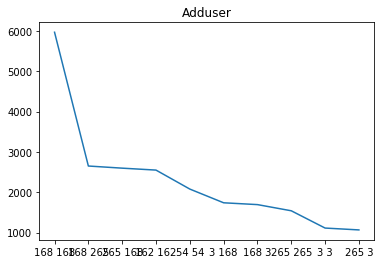

('168 168', '168 265', '265 168', '162 162', '54 54', '3 168', '168 3', '265 265', '3 3', '265 3')
(5964, 2650, 2597, 2549, 2079, 1739, 1694, 1541, 1113, 1067)


In [78]:
dic_addusr = defaultdict(lambda: 0)
x_addusr = []
y_addusr = []
x_addusr, y_addusr = load_attack_files("ADFA-LD/Attack_Data_Master/", x_addusr, y_addusr, 'Adduser')
for d in x_addusr:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        #print(index)
        dic_addusr[index] = dic_addusr[index] + 1
#print(dic_addusr)

lists = sorted(dic_addusr.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Adduser")
plt.plot(px, py)
plt.show()
print(px)
print(py)

### Hydra FTP

In [ ]:
dic_ftp = defaultdict(lambda: 0)
x_ftp = []
y_ftp = []
x_ftp, y_ftp = load_attack_files("ADFA-LD/Attack_Data_Master/", x_ftp, y_ftp, 'Hydra_FTP')
for d in x_ftp:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_ftp[index] = dic_ftp[index] + 1

lists = sorted(dic_ftp.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Hydra FTP")
plt.plot(px, py)
plt.show()
print(px)
print(py)

### Hydra SSH

In [ ]:
dic_ssh = defaultdict(lambda: 0)
x_ssh = []
y_ssh = []
x_ssh, y_ssh = load_attack_files("ADFA-LD/Attack_Data_Master/", x_ssh, y_ssh, 'Hydra_SSH')
for d in x_ssh:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_ssh[index] = dic_ssh[index] + 1

lists = sorted(dic_ssh.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Hydra SSH")
plt.plot(px, py)
plt.show()
print(px)
print(py)

### Java Meterpreter

In [ ]:
dic_java = defaultdict(lambda: 0)
x_java = []
y_java = []
x_java, y_java = load_attack_files("ADFA-LD/Attack_Data_Master/", x_java, y_java, 'Java_Meterpreter')
for d in x_java:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i + n])
        dic_java[index] = dic_java[index] + 1

lists = sorted(dic_java.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Java Meterpreter")
plt.plot(px, py)
plt.show()
print(px)
print(py)

### Meterpreter

In [ ]:
dic_met = defaultdict(lambda: 0)
x_met = []
y_met = []
x_met, y_met = load_attack_files("ADFA-LD/Attack_Data_Master/", x_met, y_met, 'Meterpreter')
for d in x_met:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_met[index] = dic_met[index] + 1

lists = sorted(dic_met.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Meterpreter")
plt.plot(px, py)
plt.show()
print(px)
print(py)


### Web Shell

In [ ]:
dic_web = defaultdict(lambda: 0)
x_web = []
y_web = []
x_web, y_web = load_attack_files("ADFA-LD/Attack_Data_Master/", x_web, y_web, 'Web_Shell')
for d in x_web:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_web[index] = dic_web[index] + 1

lists = sorted(dic_web.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists[left:right]) # unpack a list of pairs into two tuples

plt.title("Web Shell")
plt.plot(px, py)
plt.show()
print(px)
print(py)

### 攻擊序列中 n-gram之累積數分布與power law

### n = 1 的情況 

In [ ]:
n = 1
dic_xa = defaultdict(lambda: 0)
for d in xa:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
print(len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.title("one system call")
plt.plot(x_axis[1:], py)
plt.show()
#print(px)
print(py)

#for i in range(len(a_axis)):
#    a_axis[1:]
#for 
#PLNumlog[i] = math.log10(PLNum[i])
#Numlog[i] = math.log10(Num[i])

results = powerlaw.Fit(py)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
results.plot_pdf( color= 'b')
print("alpha:", results.power_law.alpha)
print("Xmin:", results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

### n >= 2 的情況 

In [ ]:
n = 3
dic_xa = defaultdict(lambda: 0)
for d in xa:
    data = d.strip().split(' ')
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
print(len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.title("one system call")
plt.plot(x_axis[1:], py)
plt.show()
#print(px)


results = powerlaw.Fit(py)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
results.plot_pdf( color= 'b')
print("alpha:", results.power_law.alpha)
print("Xmin:", results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

## train data中system call序列長度分佈

In [ ]:
train_len = []
for i in range(len(xt)):
    train_len.append(len(xt[i]))
train_len.sort()
Y = np.array(train_len)
print(Y)

## 特定system call 組合在train data中的單序列呼叫次數分佈

In [ ]:
target = [78,78]
cmd_len = len(target)
cmd_index = ' '.join([str(v) for v in target])
commend_count = []
for d in xt:
    count = 0
    data = d.strip().split(' ')
    for i in range(len(d)):
        #print(' '.join(data[i:i+n]))
        if cmd_index == ' '.join(data[i:i+cmd_len]):
            count = count + 1
    commend_count.append(count)

for d in xv:
    count = 0
    data = d.strip().split(' ')
    for i in range(len(d)):
        #print(' '.join(data[i:i+n]))
        if cmd_index == ' '.join(data[i:i+cmd_len]):
            count = count + 1
    commend_count.append(count)


In [ ]:
#print(max(commend_count))
#print(commend_count)
sta = np.zeros(max(commend_count)+1)
print(len(sta))
x_axis = np.zeros(max(commend_count)+1)
for i in range(max(commend_count)+1):
    x_axis[i] = i

for i in commend_count:
    sta[i] = sta[i] + 1
print(x_axis)
#print(len(x_axis))
#plt.plot(x_axis[1:-2500], sta[1:-2500])
plt.plot(x_axis[1:], sta[1:])
plt.show()

In [ ]:
results = powerlaw.Fit(sta)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
results.plot_pdf( color= 'b')
print("alpha:", results.power_law.alpha)
print("Xmin:", results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')